In [8]:
import keras
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imshow', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from skimage.color import gray2rgb
from skimage.io import imshow
import h5py
from numpy.random import seed
#seed(1)
from tensorflow import set_random_seed
#set_random_seed(2)
from numpy.random import RandomState
rng = RandomState(0)

import keras.backend as K
import os 
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
config = tf.ConfigProto(device_count = {'GPU': 1})
config.gpu_options.per_process_gpu_memory_fraction = 0.2
sess = tf.Session(config=config)
K.set_session(sess)


Using TensorFlow backend.


In [10]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (128, 128, 3)

/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


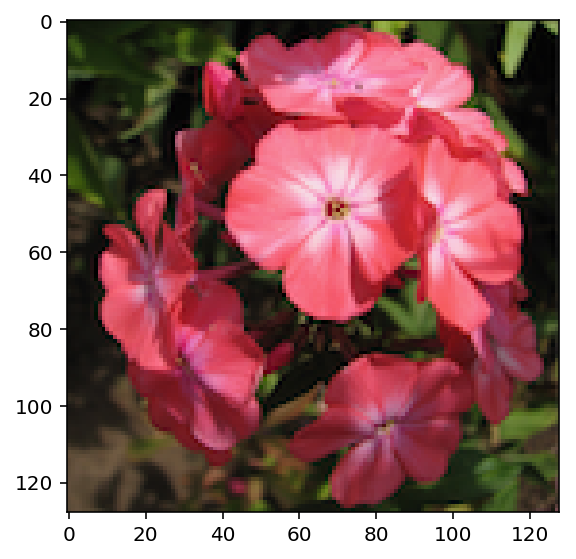

In [11]:
f = h5py.File('flower-color-images/FlowerColorImages.h5', 'r')
images = f.get("images")
labels = f.get("labels")
imshow(images[0]/255.0)

In [12]:
X = images[:]/255
y = labels[:]
num_classes = np.unique(labels).size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [13]:
from keras.layers import Input, Dense, MaxPooling2D, Conv2D, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Model
#from keras_sequential_ascii import keras2ascii
from keras.optimizers import SGD

def backbone_model_simple_1(img_shape):
    input_layer = Input(shape=img_shape)
    
    x = Conv2D(32, (3,3), padding='same', activation='relu', name='backbone_conv1')(input_layer)
    x = Conv2D(32, (3,3), padding='same', activation='relu', name='backbone_conv2')(x)
    x = MaxPooling2D(pool_size=(2,2), name='backbone_max1')(x)
    #output = Dropout(0.25)(x)
    output = x
    
    model = Model(inputs=input_layer, outputs=output, name="backbone_simple")
    
    return model


def get_model(img_shape, 
              num_classes,
              backbone_model_fn = None,
              num_dense = 1024):
    
    backbone = backbone_model_fn(img_shape)
    input_layer = Input(shape=img_shape)
    
    x = backbone(input_layer)
    x = Flatten(name='top_flatten1')(x)
    #x = Dropout(0.2, name='top_dropout1')(x)
    x = Dense(num_dense, activation='relu', name='top_dense1')(x)
    #x = Dropout(0.2, name='top_dropout2')(x)
    output = Dense(num_classes, activation='softmax', name='top_output')(x)
    
    model = Model(inputs=input_layer, outputs=output, name='net')
    
    return backbone, model

backbone, model = get_model(X_train.shape[1:],
                            num_classes,
                            backbone_model_simple_1,
                            num_dense = 1024 )

In [14]:
backbone.summary()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
backbone_conv1 (Conv2D)      (None, 128, 128, 32)      896       
_________________________________________________________________
backbone_conv2 (Conv2D)      (None, 128, 128, 32)      9248      
_________________________________________________________________
backbone_max1 (MaxPooling2D) (None, 64, 64, 32)        0         
Total params: 10,144
Trainable params: 10,144
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
backbo

In [15]:
model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['acc'])

from keras.utils import to_categorical
y_train_pre = to_categorical(y_train, num_classes)
y_val_pre = to_categorical(y_val, num_classes)
model_train = model.fit(X_train, y_train_pre,
                                   epochs=1,
                                   batch_size=10,
                                   validation_data=(X_val, y_val_pre))

Train on 168 samples, validate on 21 samples
Epoch 1/1
168/168 [==============================] - 26s 156ms/step - loss: 13.8671 - acc: 0.0833 - val_loss: 14.5830 - val_acc: 0.0952


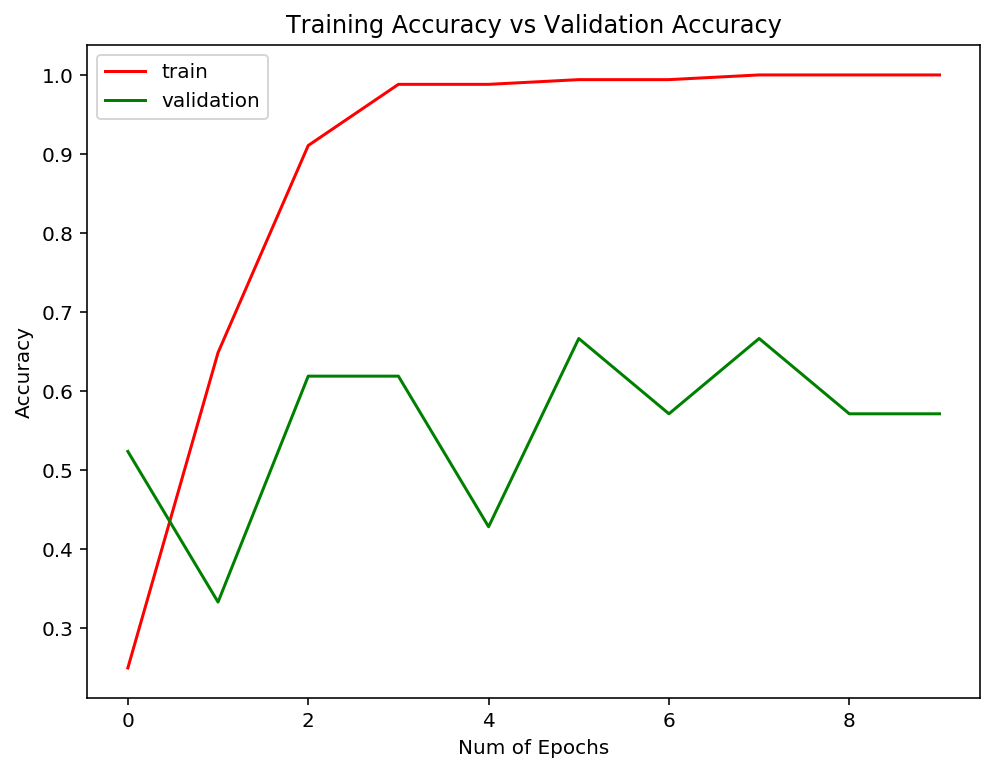

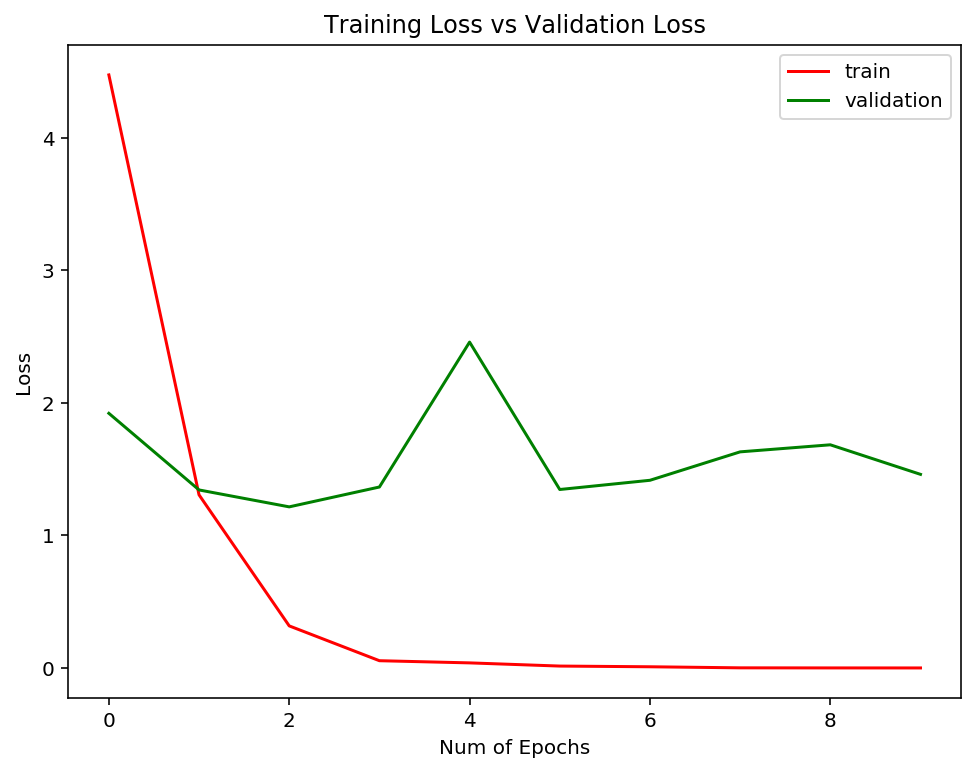

In [15]:
plt.figure(0)
plt.plot(model_train.history['acc'],'r')
plt.plot(model_train.history['val_acc'],'g')
#plt.xticks(np.arange(0, 40, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(model_train.history['loss'],'r')
plt.plot(model_train.history['val_loss'],'g')
#plt.xticks(np.arange(0, 40, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

In [20]:
# CNN
from keras.models import Sequential
from keras.layers import Activation

def cnn_mc_model():
    model = Sequential()

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(96, (5, 5)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

#     model.add(Flatten())
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(512, activation='tanh'))
    model.add(Dropout(0.25)) 
    
#    model.add(Dense(256, activation='tanh'))
#    model.add(Dropout(0.25)) 
    
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.25)) 

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

In [21]:
cnn_mc_model = cnn_mc_model()

In [26]:
#cnn_mc_checkpointer = ModelCheckpoint(filepath='weights.best.cnn_mc.flowers.hdf5', 
 #                                     verbose=2, save_best_only=True)
cnn_mc_history = cnn_mc_model.fit(X_train, y_train_pre, 
                                  epochs=50, batch_size=64,
                                  validation_data=(X_val, y_val_pre),
                                )



Train on 168 samples, validate on 21 samples
Epoch 1/50
168/168 [==============================] - 0s 2ms/step - loss: 1.3189 - acc: 0.5119 - val_loss: 1.4444 - val_acc: 0.5238
Epoch 2/50
168/168 [==============================] - 0s 2ms/step - loss: 1.2723 - acc: 0.5833 - val_loss: 1.4957 - val_acc: 0.4762
Epoch 3/50
168/168 [==============================] - 0s 2ms/step - loss: 1.1185 - acc: 0.5952 - val_loss: 1.3035 - val_acc: 0.5714
Epoch 4/50
168/168 [==============================] - 0s 2ms/step - loss: 1.3986 - acc: 0.5417 - val_loss: 1.8460 - val_acc: 0.2381
Epoch 5/50
168/168 [==============================] - 0s 2ms/step - loss: 1.4444 - acc: 0.4821 - val_loss: 1.2381 - val_acc: 0.5714
Epoch 6/50
168/168 [==============================] - 0s 2ms/step - loss: 1.1060 - acc: 0.6250 - val_loss: 1.1232 - val_acc: 0.5714
Epoch 7/50
168/168 [==============================] - 0s 2ms/step - loss: 1.0343 - acc: 0.6250 - val_loss: 1.1345 - val_acc: 0.6190
Epoch 8/50
168/168 [===========